 <font color = 'black' > <font size = '5' >Loading Data and Feature Engineering

This file is to load the initial chosen data to tell whether these variables can fit with each other (say, whether choosing them will reduce the size of the data set tremendously).

In [1]:
# basic python tools for numbers and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# statistics tools
import scipy.stats as stats

# machine learning tools
from sklearn import preprocessing 
# from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

from sklearn import metrics

# other tools
from functools import reduce
from imblearn.over_sampling import SMOTE
import itertools
import copy

# Clear warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# show plots inline
%matplotlib inline

In [2]:
def clean_epsilon(cell):
    if cell - 0.0 < 0.0001:
        return 0
    return cell

In [3]:
# Load demo data
demo = pd.read_sas('DEMO.XPT')
demo_B = pd.read_sas('DEMO_B.XPT')
demo_C = pd.read_sas('DEMO_C.XPT')

In [4]:
combine = [demo, demo_B, demo_C]
chosen_list = ['SEQN','RIAGENDR','RIDAGEYR', 'RIDRETH1',\
               'INDFMINC', 'DMDHREDU','DMDHRMAR']
demo_com = pd.DataFrame(columns = chosen_list)
for idx, df in enumerate(combine):
    demo_idx = combine[idx][chosen_list]
    demo_com = pd.concat([demo_com, demo_idx])
demo_com = demo_com.applymap(clean_epsilon)
demo_com.to_csv("DEMO_COM1.csv",index=False,sep=',')
demo_com.describe()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,INDFMINC,DMDHREDU,DMDHRMAR
count,31126.000000,31126.000000,31126.000000,31126.00000,30593.000000,30030.000000,28487.000000
mean,15563.500000,1.512176,29.669440,2.72290,8.742425,3.112254,2.523818
std,8985.446576,0.499860,25.019183,1.22403,14.202004,1.380306,5.566678
min,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000
25%,7782.250000,1.000000,10.000000,1.00000,4.000000,2.000000,1.000000
50%,15563.500000,2.000000,19.000000,3.00000,6.000000,3.000000,1.000000
75%,23344.750000,2.000000,48.000000,4.00000,10.000000,4.000000,3.000000
max,31126.000000,2.000000,85.000000,5.00000,99.000000,9.000000,99.000000


In [5]:
new_demo_name = ['SEQN', 'gender', 'age', 'race',\
                 'FMincome', 'education', 'marital_status']
demo_com.columns = new_demo_name
demo_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31126 entries, 0 to 10121
Data columns (total 7 columns):
SEQN              31126 non-null float64
gender            31126 non-null float64
age               31126 non-null float64
race              31126 non-null float64
FMincome          30593 non-null float64
education         30030 non-null float64
marital_status    28487 non-null float64
dtypes: float64(7)
memory usage: 1.9 MB


We can spot from the information above that the amount of missing values in demographic files are not overwhelming, so that we can use those "perfect" data without missing values to predict these missing values. Before doing this, we should prove these missing values are predictable ( but it cannot be fully related, which will make it meaningless to include this column). 

As there are no missing values for gender, age and race, we can firstly check whether there can be some relationship between these variables and those who have missing values, and then we can predict the missing values by those variables.

Also, we keep the values being "7"/"77"/"777"/"9"/"99"/"999" etc. as they contain information like "refuse to answer" and "don't know". Besides, when there are too many missing values, we tend to keep them as it might also contain some information.

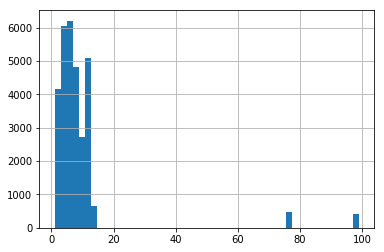

In [6]:
# We plot the income variable so that we can make sure 
# filling missing values with mean values will not influence the distribution tremendously
demo_com['FMincome'].dropna().hist(bins=50)

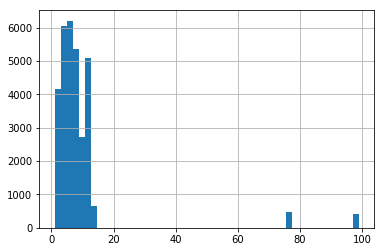

In [7]:
# There are just few missing values in 'FMincome' (family income), we can use the mean value to replace them.
demo_com['FMincome'] = demo_com['FMincome'].fillna(demo_com['FMincome'].dropna().mean())
demo_com['FMincome'].dropna().hist(bins=50)

We can see that the distribution of income has hardly changed, meaning it is reasonable to fill the missing values with the mean value.

In [8]:
# There are such a few missing values in 'education' (interviewee's education level)
# We can try to use random forest to predict the missing values of 'education'
# Firstly, we check whether it is predictable by those variables who do not have missing values
demo_x = demo_com.iloc[:,0:5]
demo_edu = demo_com[['SEQN','education']].dropna()
proof1 = pd.merge(demo_x, demo_edu, on = 'SEQN', sort = False)
proof1 = proof1.drop('SEQN', axis = 1)
proof1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30030 entries, 0 to 30029
Data columns (total 5 columns):
gender       30030 non-null float64
age          30030 non-null float64
race         30030 non-null float64
FMincome     30030 non-null float64
education    30030 non-null float64
dtypes: float64(5)
memory usage: 1.4 MB


In [9]:
# We use linear regression model to tell whether there are some relationship between these variables
x_reg = proof1.iloc[:,0:4]
y_reg = proof1.iloc[:,4]

# Create linear regression object
LinearRegressionModel_one= linear_model.LinearRegression()

# Train the model using the training sets
LinearRegressionModel_one.fit(x_reg, y_reg)
z_reg=LinearRegressionModel_one.predict(x_reg)

# The intercept value
print('Intercept Value:', LinearRegressionModel_one.intercept_)

# The coefficients
print('Coefficients:', LinearRegressionModel_one.coef_)

# The mean squared error
print("Mean squared error:",np.mean((z_reg - y_reg) ** 2))

# The model score
print("R^2", LinearRegressionModel_one.score(x_reg, y_reg))

Intercept Value: 2.2738323604195547
Coefficients: [-0.0022767  -0.00154738  0.31089552  0.00451517]
Mean squared error: 1.7576126545066775
R^2 0.07745641881111354


In [10]:
# There's little relationship between the chosen x's and y
# but we still can use random forest to give a prediction for missing values
demo_known = demo_com[demo_com['education'].notnull()] # those not-null education values
demo_known_x = demo_known[['gender','age','race','FMincome']] # set inputting x
demo_known_y = demo_known[['education']] # set inputting y
demo_known_x = demo_known_x.astype(float) # change data type to float
demo_known_y = demo_known_y.astype(float)
demo_unknown = demo_com[demo_com['education'].isnull()]
demo_unknown_x = demo_unknown[['gender','age','race','FMincome']].astype(float)
demo_unknown_y = demo_unknown['education'].astype(float)
fc = RandomForestClassifier()
fc.fit(demo_known_x, demo_known_y)
pr = fc.predict(demo_unknown_x)
print(len(pr),"missing values of education have been predicted by random forest")

1096 missing values of education have been predicted by random forest


In [11]:
# Fill the missing values with predicted data
demo_com.loc[(demo_com['education'].isnull()), 'education'] = pr
demo_com = demo_com
demo_com.describe()

,SEQN,gender,age,race,FMincome,education,marital_status
count,31126.000000,31126.000000,31126.000000,31126.00000,31126.000000,31126.000000,28487.000000
mean,15563.500000,1.512176,29.669440,2.72290,8.742425,3.105475,2.523818
std,8985.446576,0.499860,25.019183,1.22403,14.079878,1.380632,5.566678
min,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000
25%,7782.250000,1.000000,10.000000,1.00000,4.000000,2.000000,1.000000
50%,15563.500000,2.000000,19.000000,3.00000,6.000000,3.000000,1.000000
75%,23344.750000,2.000000,48.000000,4.00000,10.000000,4.000000,3.000000
max,31126.000000,2.000000,85.000000,5.00000,99.000000,9.000000,99.000000


In [12]:
# Do the same thing for the 'marital_status' column
demo_known = demo_com[demo_com['marital_status'].notnull()] # those not-null education values
demo_known_x = demo_known[['gender','age','race','FMincome']] # set inputting x
demo_known_y = demo_known[['marital_status']] # set inputting y
demo_known_x = demo_known_x.astype(float) # change data type to float
demo_known_y = demo_known_y.astype(float)
demo_unknown = demo_com[demo_com['marital_status'].isnull()]
demo_unknown_x = demo_unknown[['gender','age','race','FMincome']].astype(float)
demo_unknown_y = demo_unknown['marital_status'].astype(float)
fc = RandomForestClassifier()
fc.fit(demo_known_x, demo_known_y)
pr = fc.predict(demo_unknown_x)
print(len(pr),"missing values of marital_status have been predicted by random forest")

2639 missing values of marital_status have been predicted by random forest


In [13]:
# Fill the missing values with predicted data
demo_com.loc[(demo_com['marital_status'].isnull()), 'marital_status'] = pr
demo_com = demo_com
demo_com.describe()

,SEQN,gender,age,race,FMincome,education,marital_status
count,31126.000000,31126.000000,31126.000000,31126.00000,31126.000000,31126.000000,31126.000000
mean,15563.500000,1.512176,29.669440,2.72290,8.742425,3.105475,2.481848
std,8985.446576,0.499860,25.019183,1.22403,14.079878,1.380632,5.474037
min,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000
25%,7782.250000,1.000000,10.000000,1.00000,4.000000,2.000000,1.000000
50%,15563.500000,2.000000,19.000000,3.00000,6.000000,3.000000,1.000000
75%,23344.750000,2.000000,48.000000,4.00000,10.000000,4.000000,3.000000
max,31126.000000,2.000000,85.000000,5.00000,99.000000,9.000000,99.000000


In [14]:
demo_com.to_csv("DEMO_COM2.csv",index=False,sep=',')

In [15]:
alco = pd.read_sas('ALQ.XPT')
alco_B = pd.read_sas('ALQ_B.XPT')
alco_C = pd.read_sas('ALQ_C.XPT')

In [16]:
combine = [alco, alco_B, alco_C]
chosen_list = ['SEQN', 'ALQ100', 'ALQ120Q', 'ALQ120U']
chosen_list_2 = ['SEQN', 'ALD100', 'ALQ120Q', 'ALQ120U']
chosen_list_3 = ['SEQN', 'ALQ101', 'ALQ120Q', 'ALQ120U']

alco_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    if idx == 0:
        alco_idx = combine[idx][chosen_list]
    elif idx == 1:
        alco_idx = combine[idx][chosen_list_2]
    else:
        alco_idx = combine[idx][chosen_list_3]
    alco_idx.columns = chosen_list
    alco_com = pd.concat([alco_com, alco_idx])
    
alco_com = alco_com.applymap(clean_epsilon)
alco_com.to_csv("ALQ_COM1.csv",index=False,sep=',')
alco_com.describe()

,SEQN,ALQ100,ALQ120Q,ALQ120U
count,14213.000000,13094.000000,11094.000000,8325.000000
mean,15750.352213,1.327020,5.290247,1.937177
std,8990.543381,0.491406,38.080096,0.866105
min,2.000000,1.000000,0.000000,1.000000
25%,7952.000000,1.000000,1.000000,1.000000
50%,15846.000000,1.000000,2.000000,2.000000
75%,23591.000000,2.000000,3.000000,3.000000
max,31125.000000,9.000000,999.000000,3.000000


In [17]:
df1 = pd.merge(demo_com, alco_com, on = 'SEQN', left_index =  True, sort = False)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14213 entries, 0 to 4741
Data columns (total 10 columns):
SEQN              14213 non-null float64
gender            14213 non-null float64
age               14213 non-null float64
race              14213 non-null float64
FMincome          14213 non-null float64
education         14213 non-null float64
marital_status    14213 non-null float64
ALQ100            13094 non-null float64
ALQ120Q           11094 non-null float64
ALQ120U           8325 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


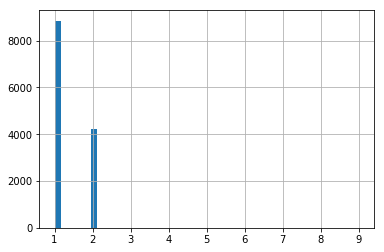

In [18]:
# As what we did above, we check the distribution of 'ALQ100'
# 'ALQ100' stands for 'Had at least 12 alcohol drinks/1 yr?'
df1['ALQ100'].hist(bins=50)

In [19]:
# Same as before, we check whether 'ALQ100' is predictable 
alco_x = df1.iloc[:,0:7]
alco_100 = df1[['SEQN','ALQ100']].dropna()
proof2 = pd.merge(alco_x, alco_100, on = 'SEQN', sort = False)
proof2 = proof2.drop('SEQN', axis = 1)
proof2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13094 entries, 0 to 13093
Data columns (total 7 columns):
gender            13094 non-null float64
age               13094 non-null float64
race              13094 non-null float64
FMincome          13094 non-null float64
education         13094 non-null float64
marital_status    13094 non-null float64
ALQ100            13094 non-null float64
dtypes: float64(7)
memory usage: 818.4 KB


In [20]:
# We use linear regression model to tell whether there are some relationship between these variables
x_reg = proof2.iloc[:,0:2] 
# It's interesting to find that gender and age can tell the most of whether the person drinks frequently/
y_reg = proof2.iloc[:,6]

# Create linear regression object
LinearRegressionModel_two = linear_model.LinearRegression()

# Train the model using the training sets
LinearRegressionModel_two.fit(x_reg, y_reg)
z_reg=LinearRegressionModel_two.predict(x_reg)

# The intercept value
print('Intercept Value:', LinearRegressionModel_two.intercept_)

# The coefficients
print('Coefficients:', LinearRegressionModel_two.coef_)

# The mean squared error
print("Mean squared error:",np.mean((z_reg - y_reg) ** 2))

# The model score
print("R^2", LinearRegressionModel_two.score(x_reg, y_reg))

Intercept Value: 0.7603005743865802
Coefficients: [0.2758483  0.00294401]
Mean squared error: 0.2198624756389001
R^2 0.08945220484213101


In [21]:
# Similar as before, it is predictable, but not strong correlated.
# We still use random forest to predict the missing values.
alco_known = df1[df1['ALQ100'].notnull()] # those not-null education values
alco_known_x = alco_known[['gender','age']] # set inputting x
alco_known_y = alco_known[['ALQ100']] # set inputting y
alco_known_x = alco_known_x.astype(float) # change data type to float
alco_known_y = alco_known_y.astype(float)
alco_unknown = df1[df1['ALQ100'].isnull()]
alco_unknown_x = alco_unknown[['gender','age']].astype(float)
alco_unknown_y = alco_unknown['ALQ100'].astype(float)
fc = RandomForestClassifier()
fc.fit(alco_known_x, alco_known_y)
pr = fc.predict(alco_unknown_x)
print(len(pr),"missing values of marital_status have been predicted by random forest")

1119 missing values of marital_status have been predicted by random forest


In [22]:
# Fill the missing values with predicted data
df1.loc[(df1['ALQ100'].isnull()), 'ALQ100'] = pr
df1 = df1
df1.rename(columns = {'ALQ100':'alco_frequency'}, inplace = True)
df1.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,ALQ120Q,ALQ120U
count,14213.000000,14213.000000,14213.000000,14213.000000,14213.00000,14213.000000,14213.000000,14213.000000,11094.000000,8325.000000
mean,15750.352213,1.526138,49.766481,2.769648,8.69194,3.174207,2.262647,1.310772,5.290247,1.937177
std,8990.543381,0.499334,19.133925,1.110609,13.32414,1.388624,3.962608,0.483642,38.080096,0.866105
min,2.000000,1.000000,20.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7952.000000,1.000000,33.000000,2.000000,4.00000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,15846.000000,2.000000,48.000000,3.000000,6.00000,3.000000,1.000000,1.000000,2.000000,2.000000
75%,23591.000000,2.000000,66.000000,3.000000,10.00000,4.000000,3.000000,2.000000,3.000000,3.000000
max,31125.000000,2.000000,85.000000,5.000000,99.00000,9.000000,99.000000,9.000000,999.000000,3.000000


Now we proceed to deal with ALQ120Q & 120U.
From the meaning of ALQ120Q & ALQ120U, it is easy for us to tell that the product of these two variables represent the days a person smokes over past 12 months.
For missing values in ALQ120Q, we know that this variable also represents the frequency of drinking
The level of 'ALQ120U' tends to be determined by ALQ120Q and alco_frequency - when the frequency is high, people intend to answer many days (more than 30) in the unit of "3", and vice versa.
So we can use the two variables ('ALQ120U', 'ALQ120Q') to predict 'ALQ120U'.
And for the missing values in ALQ120Q, we intend 

In [23]:
# When the value of 'ALQ120Q' is larger than 30, the unit has to be 'year' (encoded as 3)
unit = df1[df1['ALQ120Q']>30]['ALQ120U']<3
unit.describe()

count       122
unique        1
top       False
freq        122
Name: ALQ120U, dtype: object

In [24]:
dfqu = df1[['ALQ120Q', 'ALQ120U']]
for i in range(0, len(dfqu)):
    if dfqu.iloc[i,0] >= 30:
        dfqu.iloc[i,1] = 3
df1[['ALQ120Q', 'ALQ120U']] = dfqu

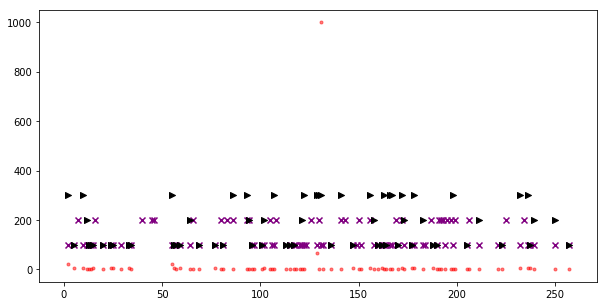

In [25]:
# For other values, we cannot find a necessary relationship between ALQ120Q and ALQ120U.
# We first look at the distribution of the two variables (with comparison to alco_frequency)
# The total amount of samples are too overwhelming so that we just look at the first 100 samples.
fig = plt.figure(figsize=(10,5))
x = df1['SEQN'][0:100]
y1 = df1['ALQ120Q'][0:100]
y2 = df1['alco_frequency'][0:100]*100
y3 = df1['ALQ120U'][0:100]*100
plt.scatter(x,y1,marker='.',alpha=0.5,color='red')
plt.scatter(x,y2,marker='x',alpha=1,color='purple')
plt.scatter(x,y3,marker='>',alpha=1,color='black')

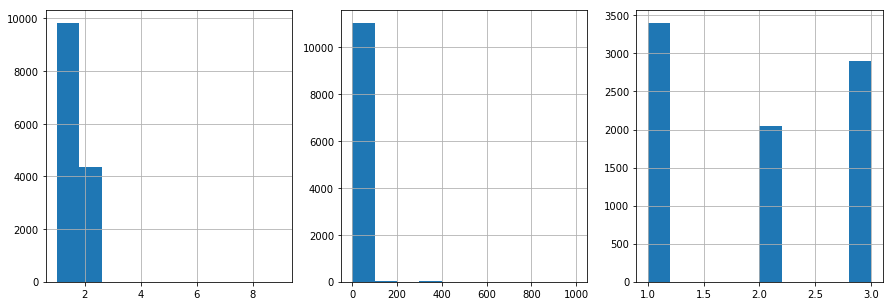

In [26]:
# The histogram graphs of these three variables
plt.figure(figsize = (15,5))
fig1 = plt.subplot(131)
ax1 = df1['alco_frequency'].hist(bins = 10)
fig2 = plt.subplot(132)
ax2 = df1['ALQ120Q'].hist(bins = 10)
fig3 = plt.subplot(133)
ax3 = df1['ALQ120U'].hist(bins = 10)
plt.show()

We can discover that there truly exists some relationship between ALQ120U and alco_frequency.
So we still use random forest to predict the missing values of 'ALQ120U'

In [27]:
unit_known = df1[df1['ALQ120U'].notnull()] # those not-null education values
unit_known_x = unit_known[['gender','age','alco_frequency']] # set inputting x
unit_known_y = unit_known[['ALQ120U']] # set inputting y
unit_known_x = unit_known_x.astype(float) # change data type to float
unit_known_y = unit_known_y.astype(float)
unit_unknown = df1[df1['ALQ120U'].isnull()]
unit_unknown_x = unit_unknown[['gender','age','alco_frequency']].astype(float)
unit_unknown_y = unit_unknown['ALQ120U'].astype(float)
fc = RandomForestClassifier()
fc.fit(unit_known_x, unit_known_y)
pr = fc.predict(unit_unknown_x)
print(len(pr),"missing values of marital_status have been predicted by random forest")

5877 missing values of marital_status have been predicted by random forest


In [28]:
df1.loc[(df1['ALQ120U'].isnull()), 'ALQ120U'] = pr
df1 = df1
df1.rename(columns = {'ALQ120U':'unit'}, inplace = True)
df1.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,ALQ120Q,unit
count,14213.000000,14213.000000,14213.000000,14213.000000,14213.00000,14213.000000,14213.000000,14213.000000,11094.000000,14213.000000
mean,15750.352213,1.526138,49.766481,2.769648,8.69194,3.174207,2.262647,1.310772,5.290247,2.098572
std,8990.543381,0.499334,19.133925,1.110609,13.32414,1.388624,3.962608,0.483642,38.080096,0.910075
min,2.000000,1.000000,20.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7952.000000,1.000000,33.000000,2.000000,4.00000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,15846.000000,2.000000,48.000000,3.000000,6.00000,3.000000,1.000000,1.000000,2.000000,2.000000
75%,23591.000000,2.000000,66.000000,3.000000,10.00000,4.000000,3.000000,2.000000,3.000000,3.000000
max,31125.000000,2.000000,85.000000,5.000000,99.00000,9.000000,99.000000,9.000000,999.000000,3.000000


In [29]:
def rf(df, column_name, predictor):
    column_known = df[df[column_name].notnull()] # those not-null education values
    column_known_x = column_known[predictor] # set inputting x
    column_known_y = column_known[[column_name]] # set inputting y
    column_known_x = column_known_x.astype(float) # change data type to float
    column_known_y = column_known_y.astype(float)
    column_unknown = df[df[column_name].isnull()]
    column_unknown_x = column_unknown[predictor].astype(float)
    column_unknown_y = column_unknown[column_name].astype(float)
    fc = RandomForestClassifier()
    fc.fit(column_known_x, column_known_y)
    pr = fc.predict(column_unknown_x)
    print(len(pr),"missing values of marital_status have been predicted by random forest")
    return pr

In [30]:
predictor = ['gender','age']
column_name = 'ALQ120Q'
df = df1
df1.loc[(df1['ALQ120Q'].isnull()), 'ALQ120Q'] = rf(df,column_name, predictor)
df1 = df1
df1.rename(columns = {'ALQ120Q':'alco_days'}, inplace = True)
df1.describe()

3119 missing values of marital_status have been predicted by random forest


,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,unit
count,14213.000000,14213.000000,14213.000000,14213.000000,14213.00000,14213.000000,14213.000000,14213.000000,14213.000000,14213.000000
mean,15750.352213,1.526138,49.766481,2.769648,8.69194,3.174207,2.262647,1.310772,4.260255,2.098572
std,8990.543381,0.499334,19.133925,1.110609,13.32414,1.388624,3.962608,0.483642,33.700620,0.910075
min,2.000000,1.000000,20.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7952.000000,1.000000,33.000000,2.000000,4.00000,2.000000,1.000000,1.000000,0.000000,1.000000
50%,15846.000000,2.000000,48.000000,3.000000,6.00000,3.000000,1.000000,1.000000,1.000000,2.000000
75%,23591.000000,2.000000,66.000000,3.000000,10.00000,4.000000,3.000000,2.000000,3.000000,3.000000
max,31125.000000,2.000000,85.000000,5.000000,99.00000,9.000000,99.000000,9.000000,999.000000,3.000000


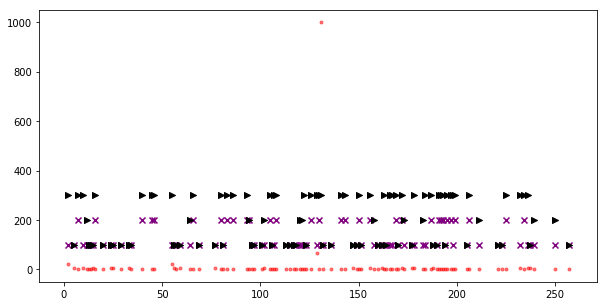

In [31]:
# We check the distribution of the variables again (after replacing missing values by random forest)
fig = plt.figure(figsize=(10,5))
x = df1['SEQN'][0:100]
y1 = df1['alco_days'][0:100]
y2 = df1['alco_frequency'][0:100]*100
y3 = df1['unit'][0:100]*100
plt.scatter(x,y1,marker='.',alpha=0.5,color='red')
plt.scatter(x,y2,marker='x',alpha=1,color='purple')
plt.scatter(x,y3,marker='>',alpha=1,color='black')

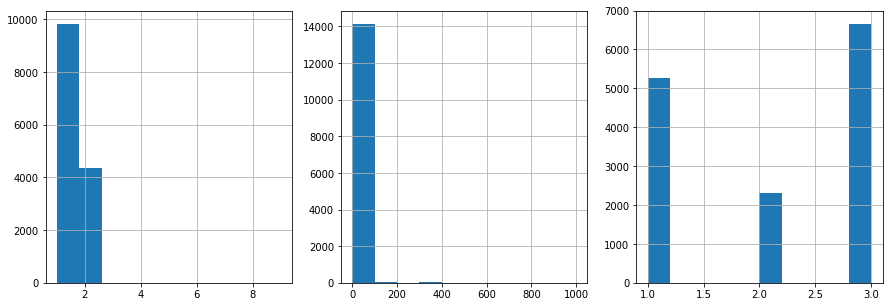

In [32]:
plt.figure(figsize = (15,5))
fig1 = plt.subplot(131)
ax1 = df1['alco_frequency'].hist(bins = 10)
fig2 = plt.subplot(132)
ax2 = df1['alco_days'].hist(bins = 10)
fig3 = plt.subplot(133)
ax3 = df1['unit'].hist(bins = 10)
plt.show()

It's reasonable to find that the number of 3.0 in the unit variable increases tremendously, because the questionis put forward like this "How often drink alcohol over past 12 mos?", and it is reasonable for questionees to forget about declaring the "year" unit again.
Now we solve the problems of missing values, then we combine the alco_days and unit columns together to form a new "alco_days" variable with mutual unit of "day".

In [33]:
for i in range(0, len(df1)):
    if df1.iloc[i,9] == 2:
        df1.iloc[i,8] * 12 # If unit == 2, the interviewee gives "month" as the unit for the days
        if df1.iloc[i,8] * 12 > 365:
            df1.iloc[i,8] = 365
    if df1.iloc[i,9] == 1:
        df1.iloc[i,8] * 4 * 12 # If unit == 2, the interviewee gives "month" as the unit for the days
        if df1.iloc[i,8] * 4 * 12 > 365:
            df1.iloc[i,8] = 365

In [34]:
df1 = df1.drop('unit', axis = 1)
df1.head()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days
0,2.0,1.0,77.0,3.0,8.000000,5.0,1.0,1.0,24.0
1,5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,4.0
2,7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,0.0
3,10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.0
4,12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,2.0


Now we check the correlation between alco_frequency and alco_days to ensure information has not been duplicated as we have predicted missing values based on alco_frequency.

In [35]:
stats.pearsonr(df1['alco_frequency'], df1['alco_days'])

(-0.022390365965669626, 0.007597763696295789)

It's good that a number close to 1 has not been given. The low correlation might be due to the "alco_frequency" variable is just a categorical vairable, providing far less information by "alco_days".

In [36]:
df1.to_csv("df1.csv",index=False,sep=',')

In [37]:
RXQANA = pd.read_sas('RXQ_ANA.XPT')
RXQANA_B = pd.read_sas('RXQANA_B.XPT')
RXQANA_C = pd.read_sas('RXQANA_C.XPT')

combine = [RXQANA, RXQANA_B, RXQANA_C]
chosen_list = ['SEQN', 'RXQ300', 'RXQ330']
chosen_list_2 = ['SEQN', 'RXD300', 'RXD330']

RXQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    if idx == 0:
        RXQ_idx = combine[idx][chosen_list]
    else:
        RXQ_idx = combine[idx][chosen_list_2]

    RXQ_idx.columns = chosen_list
    RXQ_com = pd.concat([RXQ_com, RXQ_idx])
    
RXQ_com = RXQ_com.applymap(clean_epsilon)
RXQ_com.to_csv('RXQ_com.csv', index = False, sep = ',')
RXQ_com.describe()

,SEQN,RXQ300,RXQ330
count,15956.000000,15940.000000,4202.000000
mean,15623.795625,1.747428,1.385055
std,8992.855951,0.518746,0.569180
min,2.000000,1.000000,1.000000
25%,7832.500000,1.000000,1.000000
50%,15668.500000,2.000000,1.000000
75%,23443.000000,2.000000,2.000000
max,31125.000000,9.000000,9.000000


In [38]:
df2 = pd.merge(df1, RXQ_com, on = 'SEQN', left_index =  True, sort = False)
df2.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,RXQ300,RXQ330
count,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14791.000000,3908.00000
mean,15736.992028,1.529118,50.105188,2.775909,8.661314,3.179773,2.252736,1.311850,4.215106,1.741126,1.38741
std,8978.100384,0.499168,19.124340,1.103755,13.217651,1.386681,3.942235,0.483251,33.108924,0.484358,0.57538
min,2.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000
25%,7957.750000,1.000000,33.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.00000
50%,15836.500000,2.000000,48.500000,3.000000,6.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.00000
75%,23541.500000,2.000000,66.000000,3.000000,10.000000,4.000000,3.000000,2.000000,3.000000,2.000000,2.00000
max,31125.000000,2.000000,85.000000,5.000000,99.000000,9.000000,99.000000,9.000000,999.000000,9.000000,9.00000


In [39]:
df2 = df2.fillna('0') # Fill the missing values in 'RXQ300' and 'RXQ330' with 0

In [40]:
df2['drug_status'] = 0

In [41]:
for i in range(0, len(df1)):
    if df2.iloc[i,9] == 7:
        df2.iloc[i,11] = 0 # If the interviewee refuses to answer, we regard them as missing
    elif df2.iloc[i,9] == 9:
        df2.iloc[i,11] = 0
    elif df2.iloc[i,9] == 0:
        df2.iloc[i,11] = 0
        
    elif df2.iloc[i,9] == 2:
        df2.iloc[i,11] = 3 # This new category represents those who have not taken drugs regularly
        
    if df2.iloc[i,9] == 1 and df2.iloc[i,10] == 2:
        df2.iloc[i,11] = 2 # This new category represents those who have taken but is not taking drugs regularly
        
    elif df2.iloc[i,9] == 1 and df2.iloc[i,10] == 1:
        df2.iloc[i,11] = 1 # This new category represents those who have taken and is currently taking drugs regularly
        
    elif df2.iloc[i,9] == 1.0 and df2.iloc[i,10] == 0:
        df2.iloc[i,11] = 1 # People tend to forget about this problem if they are currently taking drugs
        
    elif df2.iloc[i,9] == 1 and df2.iloc[i,10] == 7:
        df2.iloc[i,11] = 1 # People tend to forget about this problem if they are currently taking drugs
        
    elif df2.iloc[i,9] == 1 and df2.iloc[i,10] == 9:
        df2.iloc[i,11] = 1 # People tend to forget about this problem if they are currently taking drugs

    else:
        df2.iloc[i,11] = 0 # If there are some samples cannot be paired, regard them as missing value

In [42]:
df2 = df2.drop('RXQ330', axis = 1).drop('RXQ300', axis = 1)

In [43]:
df2.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status
count,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000
mean,15736.992028,1.529118,50.105188,2.775909,8.661314,3.179773,2.252736,1.311850,4.215106,0.348399
std,8978.100384,0.499168,19.124340,1.103755,13.217651,1.386681,3.942235,0.483251,33.108924,0.645561
min,2.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,7957.750000,1.000000,33.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,15836.500000,2.000000,48.500000,3.000000,6.000000,3.000000,1.000000,1.000000,1.000000,0.000000
75%,23541.500000,2.000000,66.000000,3.000000,10.000000,4.000000,3.000000,2.000000,3.000000,1.000000
max,31125.000000,2.000000,85.000000,5.000000,99.000000,9.000000,99.000000,9.000000,999.000000,2.000000


A quick explanation: In the demo file, we only have 77/99 values in FMincome/education/marital_status variables. In this case, it is natural for people to feel uncomfortable to reveal their status in either side and thus we do not use any models to predict their so-called "true" values. And if we encounter problems caused by them later, we deal with them later.
But in this data frame, it is worth solving them now.

In [44]:
df3 = copy.deepcopy(df2)
mean_alco_days = df3['alco_days'].drop(999).drop(777).mean()
median_alco_frequency = df3['alco_frequency'].drop(9).drop(7).median()

In [45]:
# Change outstanding values in alco_days
for i in range(0, len(df3)):
    if df3.iloc[i, 8] == 777:
        df3.iloc[i, 8] = mean_alco_days
    elif df3.iloc[i, 8] == 999:
        df3.iloc[i, 8] = mean_alco_days

In [46]:
# Change outstanding values in alco_frequency
for i in range(0, len(df3)):
    if df3.iloc[i, 7] == 9:
        df3.iloc[i, 7] = median_alco_frequency
df3.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status
count,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000
mean,15736.992028,1.529118,50.105188,2.775909,8.661314,3.179773,2.252736,1.309147,3.475840,0.348399
std,8978.100384,0.499168,19.124340,1.103755,13.217651,1.386681,3.942235,0.462158,18.978744,0.645561
min,2.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,7957.750000,1.000000,33.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,15836.500000,2.000000,48.500000,3.000000,6.000000,3.000000,1.000000,1.000000,1.000000,0.000000
75%,23541.500000,2.000000,66.000000,3.000000,10.000000,4.000000,3.000000,2.000000,3.000000,1.000000
max,31125.000000,2.000000,85.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000


In [47]:
df2 = copy.deepcopy(df3)
df2.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status
count,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000
mean,15736.992028,1.529118,50.105188,2.775909,8.661314,3.179773,2.252736,1.309147,3.475840,0.348399
std,8978.100384,0.499168,19.124340,1.103755,13.217651,1.386681,3.942235,0.462158,18.978744,0.645561
min,2.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,7957.750000,1.000000,33.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,15836.500000,2.000000,48.500000,3.000000,6.000000,3.000000,1.000000,1.000000,1.000000,0.000000
75%,23541.500000,2.000000,66.000000,3.000000,10.000000,4.000000,3.000000,2.000000,3.000000,1.000000
max,31125.000000,2.000000,85.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000


In [48]:
df2.to_csv("df2.csv",index=False,sep=',')

In [49]:
BPQ = pd.read_sas('BPQ.XPT')
BPQ_B = pd.read_sas('BPQ_B.XPT')
BPQ_C = pd.read_sas('BPQ_C.XPT')
BPQ.describe()

,SEQN,BPQ010,BPQ020,BPQ030,BPQ040A,BPQ040B,BPQ040C,BPQ040D,BPQ040E,BPQ040F,...,BPQ100A,BPQ100B,BPQ100C,BPQ100D,BPQ110A,BPQ110B,BPQ110C,BPQ120,BPQ130,BPQ140
count,6044.000000,6040.000000,5951.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,...,971.000000,635.000000,742.000000,570.000000,3711.000000,3711.000000,3711.000000,195.000000,531.000000,423.000000
mean,4959.859861,1.596689,1.755503,1.189295,1.203655,1.508486,1.357050,1.422977,1.768277,1.943864,...,1.178167,1.247244,1.301887,1.226316,1.690380,1.827540,1.848828,1.482051,1.691149,1.770686
std,2873.995328,1.071661,0.536916,0.513123,0.426475,0.585526,0.599201,0.611191,0.645913,0.467893,...,0.452003,0.602548,0.459386,0.418813,0.517939,0.453089,0.436907,0.500964,0.462455,0.556641
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2444.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4943.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000
75%,7442.250000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,9965.000000,9.000000,9.000000,9.000000,7.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,2.000000,2.000000,9.000000,9.000000,9.000000,2.000000,2.000000,9.000000


In [50]:
combine = [BPQ, BPQ_B, BPQ_C]
chosen_list = ['SEQN', 'BPQ020', 'BPQ060', 'BPQ100A', 'BPQ100B',\
              'BPQ100C', 'BPQ100D', 'BPQ110A', 'BPQ110B', 'BPQ110C']
chosen_list_2 = ['SEQN', 'BPQ020', 'BPQ060', 'BPQ100A', 'BPQ100B',\
              'BPQ100C', 'BPQ100D', 'BPD110A', 'BPD110B', 'BPD110C']

BPQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    if idx == 0:
        BPQ_idx = combine[idx][chosen_list]
    else:
        BPQ_idx = combine[idx][chosen_list_2]

    BPQ_idx.columns = chosen_list
    BPQ_com = pd.concat([BPQ_com, BPQ_idx])
    
BPQ_com = BPQ_com.applymap(clean_epsilon)
BPQ_com.to_csv('BPQ_com.csv', index = False, sep = ',')
BPQ_com.describe()

,SEQN,BPQ020,BPQ060,BPQ100A,BPQ100B,BPQ100C,BPQ100D,BPQ110A,BPQ110B,BPQ110C
count,18891.000000,18623.000000,15327.000000,3257.000000,2147.000000,2583.000000,2157.000000,11315.000000,11315.000000,11315.000000
mean,15622.100630,1.745422,1.589222,1.187903,1.231020,1.310105,1.202596,1.694300,1.835086,1.851878
std,9024.485131,0.554129,1.522671,0.432482,0.479503,0.462626,0.402027,0.542972,0.461556,0.432029
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,7773.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
50%,15687.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000
75%,23519.500000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000
max,31125.000000,9.000000,9.000000,9.000000,9.000000,2.000000,2.000000,9.000000,9.000000,9.000000


In [51]:
# Define a function to automously fill the 7&9 values with 0 (regarded as missing)
def fill_79(df):
    for idx, value in enumerate(df):
        if idx >= 1:
            for i in range(0, len(df)):
                if df.iloc[i,idx] == 7:
                    df.iloc[i,idx] = 0
                elif df.iloc[i,idx] == 9:
                    df.iloc[i,idx] = 0
                else:
                    df.iloc[i,idx] = df.iloc[i,idx]
    return df

BPQ_com = fill_79(BPQ_com)
BPQ_com.describe()

,SEQN,BPQ020,BPQ060,BPQ100A,BPQ100B,BPQ100C,BPQ100D,BPQ110A,BPQ110B,BPQ110C
count,18891.000000,18623.000000,15327.000000,3257.000000,2147.000000,2583.000000,2157.000000,11315.000000,11315.000000,11315.000000
mean,15622.100630,1.726575,1.254388,1.182376,1.222636,1.310105,1.202596,1.680071,1.821829,1.841008
std,9024.485131,0.450403,0.514132,0.387801,0.418347,0.462626,0.402027,0.470056,0.386808,0.369293
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,7773.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
50%,15687.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000
75%,23519.500000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000
max,31125.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [52]:
BPQ_com = BPQ_com.fillna(0)
BPQ_com.describe()

,SEQN,BPQ020,BPQ060,BPQ100A,BPQ100B,BPQ100C,BPQ100D,BPQ110A,BPQ110B,BPQ110C
count,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000
mean,15622.100630,1.702080,1.017733,0.203854,0.138955,0.179133,0.137314,1.006299,1.091207,1.102694
std,9024.485131,0.491608,0.674777,0.474772,0.412884,0.481517,0.405873,0.900216,0.941762,0.946498
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7773.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15687.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
75%,23519.500000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000
max,31125.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [53]:
BPQ_com['BPC_status'] = 0
new = copy.deepcopy(BPQ_com)

In [54]:
# Create a signal telling the status of blood pressure and cholestorel
new['BPC_status'][new['BPQ020']==1]=1
new['BPC_status'][new['BPQ060']==1]=1

In [55]:
new['diet_status'] = 0
new['diet_status'][new['BPQ100A']==1]=1
new['diet_status'][new['BPQ100B']==1]=1
new['diet_status'][new['BPQ110A']==1]=1
new['diet_status'][new['BPQ110B']==1]=1

In [56]:
new['exercise_status'] = 0
new['exercise_status'][new['BPQ100C']==1]=1
new['exercise_status'][new['BPQ110C']==1]=1

In [57]:
new['medicine_status'] = 0
new['medicine_status'][new['BPQ100D']==1]=1

In [58]:
new = new.drop(['BPQ020', 'BPQ060', 'BPQ100A', 'BPQ100B',\
               'BPQ100C', 'BPQ100D', 'BPQ110A', 'BPQ110B', 'BPQ110C'], axis=1)

In [59]:
BPQ_com = copy.deepcopy(new)
BPQ_com.describe()

,SEQN,BPC_status,diet_status,exercise_status,medicine_status
count,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000
mean,15622.100630,0.591446,0.353290,0.187973,0.091049
std,9024.485131,0.491580,0.478004,0.390701,0.287686
min,2.000000,0.000000,0.000000,0.000000,0.000000
25%,7773.500000,0.000000,0.000000,0.000000,0.000000
50%,15687.000000,1.000000,0.000000,0.000000,0.000000
75%,23519.500000,1.000000,1.000000,0.000000,0.000000
max,31125.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
df3 = pd.merge(df2, BPQ_com, on = 'SEQN', left_index =  True, sort = False)
df3.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,BPC_status,diet_status,exercise_status,medicine_status
count,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000
mean,15736.992028,1.529118,50.105188,2.775909,8.661314,3.179773,2.252736,1.309147,3.475840,0.348399,0.723483,0.445480,0.239427,0.115930
std,8978.100384,0.499168,19.124340,1.103755,13.217651,1.386681,3.942235,0.462158,18.978744,0.645561,0.447290,0.497036,0.426748,0.320152
min,2.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7957.750000,1.000000,33.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15836.500000,2.000000,48.500000,3.000000,6.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,23541.500000,2.000000,66.000000,3.000000,10.000000,4.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,31125.000000,2.000000,85.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
df3.to_csv("df3.csv",index=False,sep=',')

In [62]:
DIQ = pd.read_sas('DIQ.XPT')
DIQ_B = pd.read_sas('DIQ_B.XPT')
DIQ_C = pd.read_sas('DIQ_C.XPT')

combine = [DIQ, DIQ_B, DIQ_C]
chosen_list = ['SEQN', 'DIQ010']

DIQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    
    DIQ_idx = combine[idx][chosen_list]

    DIQ_idx.columns = chosen_list
    DIQ_com = pd.concat([DIQ_com, DIQ_idx])
    
DIQ_com = DIQ_com.applymap(clean_epsilon)
DIQ_com.to_csv('DIQ_com.csv', index = False, sep = ',')
DIQ_com.describe()

,SEQN,DIQ010
count,29608.000000,29601.000000
mean,15571.421508,1.956995
std,8995.132777,0.281661
min,1.000000,1.000000
25%,7761.750000,2.000000
50%,15590.500000,2.000000
75%,23366.250000,2.000000
max,31126.000000,9.000000


In [63]:
def fill_79(df):
    for idx, value in enumerate(df):
        if idx >= 1:
            for i in range(0, len(df)):
                if df.iloc[i,idx] == 7:
                    df.iloc[i,idx] = 0
                elif df.iloc[i,idx] == 9:
                    df.iloc[i,idx] = 0
                else:
                    df.iloc[i,idx] = df.iloc[i,idx]
    return df

DIQ_com = fill_79(DIQ_com)
DIQ_com = DIQ_com.fillna(0)
DIQ_com.describe()

,SEQN,DIQ010
count,29608.000000,29608.000000
mean,15571.421508,1.952648
std,8995.132777,0.246817
min,1.000000,0.000000
25%,7761.750000,2.000000
50%,15590.500000,2.000000
75%,23366.250000,2.000000
max,31126.000000,3.000000


In [64]:
DIQ_com.rename(columns = {'DIQ010':'diabetes_status'}, inplace=True)
DIQ_com.describe()

,SEQN,diabetes_status
count,29608.000000,29608.000000
mean,15571.421508,1.952648
std,8995.132777,0.246817
min,1.000000,0.000000
25%,7761.750000,2.000000
50%,15590.500000,2.000000
75%,23366.250000,2.000000
max,31126.000000,3.000000


In [65]:
df4 = pd.merge(df3, DIQ_com, on = 'SEQN', left_index =  True, sort = False)
df4.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,BPC_status,diet_status,exercise_status,medicine_status,diabetes_status
count,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000,14802.000000
mean,15736.992028,1.529118,50.105188,2.775909,8.661314,3.179773,2.252736,1.309147,3.475840,0.348399,0.723483,0.445480,0.239427,0.115930,1.911431
std,8978.100384,0.499168,19.124340,1.103755,13.217651,1.386681,3.942235,0.462158,18.978744,0.645561,0.447290,0.497036,0.426748,0.320152,0.329903
min,2.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7957.750000,1.000000,33.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,15836.500000,2.000000,48.500000,3.000000,6.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
75%,23541.500000,2.000000,66.000000,3.000000,10.000000,4.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000
max,31125.000000,2.000000,85.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [66]:
df4.to_csv('df4.csv',index=False,sep=',')

In [67]:
DUQ = pd.read_sas('DUQ.XPT')
DUQ_B = pd.read_sas('DUQ_B.XPT')
DUQ_C = pd.read_sas('DUQ_C.XPT')
combine = [DUQ, DUQ_B, DUQ_C]

chosen_list = ['SEQN', 'DUQ100']

DUQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    
    DUQ_idx = combine[idx][chosen_list]

    DUQ_idx.columns = chosen_list
    DUQ_com = pd.concat([DUQ_com, DUQ_idx])
    
DUQ_com = DUQ_com.applymap(clean_epsilon)
DUQ_com.to_csv('DUQ_com.csv', index = False, sep = ',')
DUQ_com.describe()

,SEQN,DUQ100
count,9229.000000,8300.000000
mean,15709.222126,1.824458
std,8924.623241,0.550743
min,5.000000,1.000000
25%,8034.000000,2.000000
50%,15774.000000,2.000000
75%,23466.000000,2.000000
max,31125.000000,9.000000


In [68]:
def fill_79(df):
    for idx, value in enumerate(df):
        if idx >= 1:
            for i in range(0, len(df)):
                if df.iloc[i,idx] == 7:
                    df.iloc[i,idx] = 0
                elif df.iloc[i,idx] == 9:
                    df.iloc[i,idx] = 0
                else:
                    df.iloc[i,idx] = df.iloc[i,idx]
    return df

DUQ_com = fill_79(DUQ_com)
DUQ_com = DUQ_com.fillna(0)
DUQ_com.describe()

,SEQN,DUQ100
count,9229.000000,9229.000000
mean,15709.222126,1.614584
std,8924.623241,0.666890
min,5.000000,0.000000
25%,8034.000000,1.000000
50%,15774.000000,2.000000
75%,23466.000000,2.000000
max,31125.000000,2.000000


In [69]:
DUQ_com.rename(columns = {'DUQ100':'druguse'}, inplace=True)
# 'druguse' here refers to 'true' drug use, while the 'drug_status' above refers to pain killers
DUQ_com.head()

,SEQN,druguse
0,5.0,2.0
1,7.0,2.0
2,10.0,2.0
3,12.0,1.0
4,15.0,2.0


In [70]:
df5 = pd.merge(df4, DUQ_com, on = 'SEQN', left_index =  True, sort = False)
df5.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,BPC_status,diet_status,exercise_status,medicine_status,diabetes_status,druguse
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,15673.245664,1.539262,38.027541,2.778093,8.776262,3.321034,2.504152,1.261116,3.635372,0.250920,0.617366,0.385367,0.211080,0.050668,1.954588,1.615263
std,8914.277228,0.498482,11.192533,1.145004,12.700780,1.323017,4.395910,0.439266,18.271684,0.597167,0.486056,0.486708,0.408096,0.219329,0.245734,0.664321
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8011.000000,1.000000,28.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,15720.000000,2.000000,38.000000,3.000000,7.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,23415.000000,2.000000,47.000000,4.000000,10.000000,4.000000,4.000000,2.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000
max,31125.000000,2.000000,59.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000


In [71]:
df5.to_csv('df5.csv',index=False,sep=',')

In [72]:
HUQ = pd.read_sas('HUQ.XPT')
HUQ_B = pd.read_sas('HUQ_B.XPT')
HUQ_C = pd.read_sas('HUQ_C.XPT')
combine = [HUQ, HUQ_B, HUQ_C]

chosen_list = ['SEQN', 'HUQ010', 'HUQ020', 'HUQ090']

HUQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    HUQ_idx = combine[idx][chosen_list]

    HUQ_idx.columns = chosen_list
    HUQ_com = pd.concat([HUQ_com, HUQ_idx])
    
HUQ_com = HUQ_com.applymap(clean_epsilon)
HUQ_com.to_csv('HUQ_com.csv', index = False, sep = ',')
HUQ_com.describe()

,SEQN,HUQ010,HUQ020,HUQ090
count,31126.000000,31121.000000,29602.000000,27110.000000
mean,15563.500000,2.286912,2.555773,1.932571
std,8985.446576,1.131279,0.793763,0.326436
min,1.000000,1.000000,1.000000,1.000000
25%,7782.250000,1.000000,2.000000,2.000000
50%,15563.500000,2.000000,3.000000,2.000000
75%,23344.750000,3.000000,3.000000,2.000000
max,31126.000000,9.000000,9.000000,9.000000


In [73]:
def fill_79(df):
    for idx, value in enumerate(df):
        if idx >= 1:
            for i in range(0, len(df)):
                if df.iloc[i,idx] == 7:
                    df.iloc[i,idx] = 0
                elif df.iloc[i,idx] == 9:
                    df.iloc[i,idx] = 0
                else:
                    df.iloc[i,idx] = df.iloc[i,idx]
    return df

HUQ_com = fill_79(HUQ_com)
HUQ_com = HUQ_com.fillna(0)
HUQ_com.describe()

,SEQN,HUQ010,HUQ020,HUQ090
count,31126.000000,31126.000000,31126.000000,31126.000000
mean,15563.500000,2.282882,2.427585,1.676830
std,8985.446576,1.125566,0.944267,0.691572
min,1.000000,0.000000,0.000000,0.000000
25%,7782.250000,1.000000,2.000000,2.000000
50%,15563.500000,2.000000,3.000000,2.000000
75%,23344.750000,3.000000,3.000000,2.000000
max,31126.000000,5.000000,3.000000,2.000000


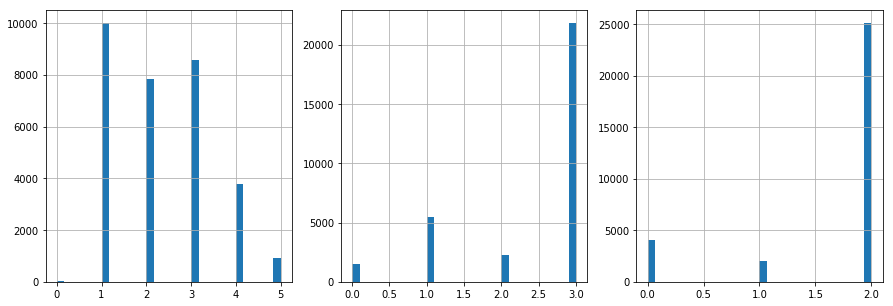

In [74]:
# Show the distribution of these variables
plt.figure(figsize = (15,5))
fig1 = plt.subplot(131)
ax1 = HUQ_com['HUQ010'].hist(bins = 30)
fig2 = plt.subplot(132)
ax2 = HUQ_com['HUQ020'].hist(bins = 30)
fig3 = plt.subplot(133)
ax3 = HUQ_com['HUQ090'].hist(bins = 30)
plt.show()

In [75]:
HUQ_com = HUQ_com.rename(columns={'HUQ010':'health_condition',\
                                  'HUQ020':'health_comparison',\
                                  'HUQ090':'mental_visit'})

In [76]:
HUQ_com.head()

,SEQN,health_condition,health_comparison,mental_visit
0,1.0,1.0,3.0,0.0
1,2.0,2.0,2.0,2.0
2,3.0,1.0,1.0,2.0
3,4.0,1.0,3.0,0.0
4,5.0,2.0,3.0,2.0


In [77]:
df6 = pd.merge(df5, HUQ_com, on = 'SEQN', left_index =  True, sort = False)
df6.to_csv('df6.csv',index=False,sep=',')
df6.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,BPC_status,diet_status,exercise_status,medicine_status,diabetes_status,druguse,health_condition,health_comparison,mental_visit
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,15673.245664,1.539262,38.027541,2.778093,8.776262,3.321034,2.504152,1.261116,3.635372,0.250920,0.617366,0.385367,0.211080,0.050668,1.954588,1.615263,2.501734,2.548513,1.914748
std,8914.277228,0.498482,11.192533,1.145004,12.700780,1.323017,4.395910,0.439266,18.271684,0.597167,0.486056,0.486708,0.408096,0.219329,0.245734,0.664321,1.091976,0.773555,0.281893
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8011.000000,1.000000,28.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,2.000000
50%,15720.000000,2.000000,38.000000,3.000000,7.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,2.000000
75%,23415.000000,2.000000,47.000000,4.000000,10.000000,4.000000,4.000000,2.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,2.000000
max,31125.000000,2.000000,59.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,5.000000,3.000000,2.000000


In [78]:
HOQ = pd.read_sas('HOQ.XPT')
HOQ_B = pd.read_sas('HOQ_B.XPT')
HOQ_C = pd.read_sas('HOQ_C.XPT')
combine = [HOQ, HOQ_B, HOQ_C]

chosen_list = ['SEQN', 'HOD010', 'HOQ065']
chosen_list_2 = ['SEQN', 'HOD011', 'HOQ065']

HOQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    if idx == 0:
        HOQ_idx = combine[idx][chosen_list]
    elif idx == 1:
        HOQ_idx = combine[idx][chosen_list]
    else:
        HOQ_idx = combine[idx][chosen_list_2]

    HOQ_idx.columns = chosen_list
    HOQ_com = pd.concat([HOQ_com, HOQ_idx])
    
HOQ_com = HOQ_com.applymap(clean_epsilon)
HOQ_com.to_csv('HOQ_com.csv', index = False, sep = ',')
HOQ_com.describe()

,SEQN,HOD010,HOQ065
count,31126.000000,30658.000000,30658.000000
mean,15563.500000,2.538750,1.440146
std,8985.446576,1.513489,0.570921
min,1.000000,1.000000,1.000000
25%,7782.250000,2.000000,1.000000
50%,15563.500000,2.000000,1.000000
75%,23344.750000,3.000000,2.000000
max,31126.000000,99.000000,9.000000


In [79]:
print("percentage of missing values: (in %)")
HOQ_com.isnull().sum()/len(HOQ_com) * 100

percentage of missing values: (in %)


SEQN      0.000000
HOD010    1.503566
HOQ065    1.503566
dtype: float64

Missing values are very few, so we can use median values to fill them. Also, for those 7 and 9 values, we also regard them as missing values and replace them with medians.

In [80]:
deal_HOQ = copy.deepcopy(HOQ_com)

In [81]:
deal_HOQ['HOQ065'] = deal_HOQ['HOQ065'].replace(7, deal_HOQ['HOQ065'].dropna().median()).\
                    replace(9, deal_HOQ['HOQ065'].dropna().median()).\
                    fillna(deal_HOQ['HOQ065'].dropna().median())

In [82]:
deal_HOQ['HOD010'] = deal_HOQ['HOD010'].replace(77, deal_HOQ['HOD010'].dropna().median()).\
                    replace(99, deal_HOQ['HOD010'].dropna().median()).\
                    fillna(deal_HOQ['HOD010'].dropna().median())

In [83]:
deal_HOQ.rename(columns={'HOD010':'home_type','HOQ065':'home_ownership'}, inplace = True)

In [84]:
HOQ_com = copy.deepcopy(deal_HOQ)

In [85]:
df7 = pd.merge(df6, HOQ_com, on = 'SEQN', left_index =  True, sort = False)
df7.to_csv('df7.csv',index=False,sep=',')
df7.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,...,diet_status,exercise_status,medicine_status,diabetes_status,druguse,health_condition,health_comparison,mental_visit,home_type,home_ownership
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,...,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,15673.245664,1.539262,38.027541,2.778093,8.776262,3.321034,2.504152,1.261116,3.635372,0.250920,...,0.385367,0.211080,0.050668,1.954588,1.615263,2.501734,2.548513,1.914748,2.526332,1.431094
std,8914.277228,0.498482,11.192533,1.145004,12.700780,1.323017,4.395910,0.439266,18.271684,0.597167,...,0.486708,0.408096,0.219329,0.245734,0.664321,1.091976,0.773555,0.281893,1.005225,0.537207
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,8011.000000,1.000000,28.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,15720.000000,2.000000,38.000000,3.000000,7.000000,3.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,1.000000
75%,23415.000000,2.000000,47.000000,4.000000,10.000000,4.000000,4.000000,2.000000,3.000000,0.000000,...,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,2.000000,4.000000,2.000000
max,31125.000000,2.000000,59.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,...,1.000000,1.000000,1.000000,3.000000,2.000000,5.000000,3.000000,2.000000,9.000000,3.000000


In [86]:
SMQ = pd.read_sas('SMQ.XPT')
SMQ_B = pd.read_sas('SMQ_B.XPT')
SMQ_C = pd.read_sas('SMQ_C.XPT')
combine = [SMQ, SMQ_B, SMQ_C]

chosen_list = ['SEQN', 'SMQ020', 'SMQ040', 'SMD070', 'SMD075', 'SMD100NI']

SMQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):

    SMQ_idx = combine[idx][chosen_list]

    SMQ_idx.columns = chosen_list
    SMQ_com = pd.concat([SMQ_com, SMQ_idx])
    
SMQ_com = SMQ_com.applymap(clean_epsilon)
SMQ_com.to_csv('SMQ_com.csv', index = False, sep = ',')
SMQ_com.describe()

,SEQN,SMQ020,SMQ040,SMD070,SMD075,SMD100NI
count,15332.000000,15324.000000,7391.000000,2708.000000,2708.000000,2837.000000
mean,15634.419319,1.528778,2.187796,17.054284,28.500739,0.964751
std,9004.980531,0.576708,0.943989,34.390976,115.118578,0.275604
min,2.000000,1.000000,1.000000,1.000000,1.000000,0.100000
25%,7819.750000,1.000000,1.000000,10.000000,4.000000,0.800000
50%,15683.000000,2.000000,3.000000,15.000000,10.000000,0.900000
75%,23481.500000,2.000000,3.000000,20.000000,22.000000,1.200000
max,31125.000000,9.000000,9.000000,999.000000,999.000000,1.800000


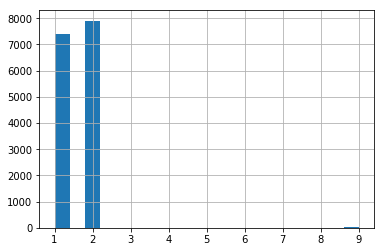

In [87]:
# See the distribution of varible 'SMQ020'
plt.figure()
fig1 = SMQ_com['SMQ020'].hist(bins=20)

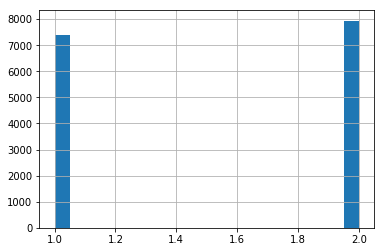

In [88]:
# From the figure above, we know that missing values are very few for this variable
# Fill the missing values, 7 and 9 values by medians
SMQ_com['SMQ020'] = SMQ_com['SMQ020'].replace(7, SMQ_com['SMQ020'].dropna().median()).\
                    replace(9, SMQ_com['SMQ020'].dropna().median()).\
                    fillna(SMQ_com['SMQ020'].dropna().median())
plt.figure()
fig1 = SMQ_com['SMQ020'].hist(bins=20)

In [89]:
SMQ_com.rename(columns={'SMQ020':'smoker_type'},inplace=True)
# 1 denotes smoker, and 2 denotes light or non smoker

In [90]:
# For SMQ040, we find that the numbers of missing values are close to those who are light or non smokers
# Hence, we simply substitute the nan values in 'SMQ040' with 3 (not currently smoking)
# And we replace 7 and 9 with 3.0, too

SMQ_com['SMQ040'] = SMQ_com['SMQ040'].fillna(3.0).replace(7,3.0).replace(9,3.0)

In [91]:
SMQ_com.rename(columns={'SMQ040':'smoking_status'},inplace=True)
SMQ_com.describe()

,SEQN,smoker_type,smoking_status,SMD070,SMD075,SMD100NI
count,15332.000000,15332.000000,15332.000000,2708.000000,2708.000000,2837.000000
mean,15634.419319,1.517871,2.608075,17.054284,28.500739,0.964751
std,9004.980531,0.499697,0.769160,34.390976,115.118578,0.275604
min,2.000000,1.000000,1.000000,1.000000,1.000000,0.100000
25%,7819.750000,1.000000,3.000000,10.000000,4.000000,0.800000
50%,15683.000000,2.000000,3.000000,15.000000,10.000000,0.900000
75%,23481.500000,2.000000,3.000000,20.000000,22.000000,1.200000
max,31125.000000,2.000000,3.000000,999.000000,999.000000,1.800000


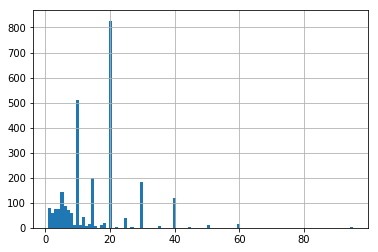

In [92]:
# Firstly we replace the '999' value with median value
# And draw the distribution of this variable
SMQ_com['SMD070'] = SMQ_com['SMD070'].replace(999, SMQ_com['SMD070'].median())
plt.figure()
fig1 = SMQ_com['SMD070'].hist(bins=100)

It's good to spot that, except the missing values, the distribution of smoking amount is in high quality. To contain as much information as we can, we substitute the missing values as 0 (as those who do not smoke now will not answer this question.

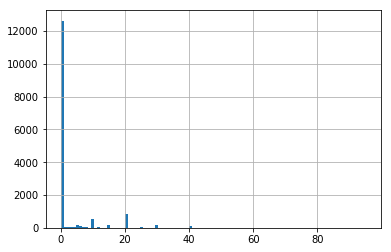

In [93]:
SMQ_com['SMD070'] = SMQ_com['SMD070'].fillna(0)
plt.figure()
fig1 = SMQ_com['SMD070'].hist(bins=100)

We can find that replacing 0 will change the distribution tremendously. It is natural as those who do not smoke are taking acount of the most percentage.

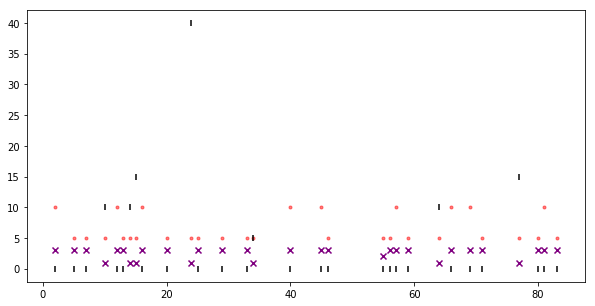

In [94]:
# We can check this correspondence by plotting the values (to make it clear, we only choose the first 30 samples)
fig = plt.figure(figsize=(10,5))
x = SMQ_com['SEQN'][0:30]
y1 = SMQ_com['smoker_type'][0:30]*5
y2 = SMQ_com['smoking_status'][0:30]
y3 = SMQ_com['SMD070'][0:30]
plt.scatter(x,y1,marker='.',alpha=0.5,color='red')
plt.scatter(x,y2,marker='x',alpha=1,color='purple')
plt.scatter(x,y3,marker='|',alpha=1,color='black')

In [95]:
# Check the distribution of smoking
smoker_amount = Counter(SMQ_com['smoker_type'])
print("The smoker amount distribution is:", smoker_amount)
smoking_amount = Counter(SMQ_com['smoking_status'])
print("The current smoking amount distribution is:", smoking_amount)

The smoker amount distribution is: Counter({2.0: 7940, 1.0: 7392})
The current smoking amount distribution is: Counter({3.0: 12031, 1.0: 2708, 2.0: 593})


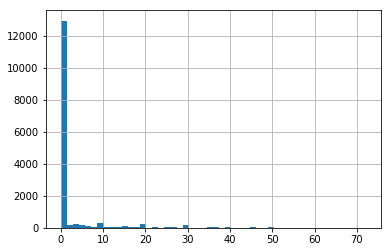

In [96]:
# Do the same thing to the 'SMD075' problem
SMQ_com['SMD075'] = SMQ_com['SMD075'].fillna(0).replace(999,0)
plt.figure()
fig1 = SMQ_com['SMD075'].hist(bins=50)

Now, to better adjust this set of variables, we transform the 'SMD070' variable into 'smoking_frequency', making it a multi-class variable with 1 denoting heavy smokers, 2 denoting moderate smokers, and 3 denoting light smokers.

In [97]:
SMQ_com['smoking_frequency'] = 2
SMQ_com['smoking_frequency'][SMQ_com['SMD070']>=20] = 1 # 20 is the original 75% percentile
SMQ_com['smoking_frequency'][SMQ_com['SMD070']<10] = 3 # 10 is the original 25% percentile
SMQ_com['smoking_frequency'][SMQ_com['SMD070']==0] = 0 # non-smokers

In [98]:
# Do the same thing to 'SMD075'
SMQ_com['smoking_time'] = 2
# 2 denotes moderate smokers
SMQ_com['smoking_time'][SMQ_com['SMD075']>=22] = 1 # 22 is the original 75% percentile
# 1 denotes long smokers
SMQ_com['smoking_time'][SMQ_com['SMD075']<4] = 3 # 4 is the original 25% percentile
# 3 denotes short smokers
SMQ_com['smoking_time'][SMQ_com['SMD075']==0] = 0 # non-smokers

In [99]:
SMQ_com = SMQ_com.drop(['SMD070', 'SMD075', 'SMD100NI'],axis=1)

In [100]:
df8 = pd.merge(df7, SMQ_com, on = 'SEQN', left_index =  True, sort = False)
df8.to_csv('df8.csv',index=False,sep=',')
df8.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,...,druguse,health_condition,health_comparison,mental_visit,home_type,home_ownership,smoker_type,smoking_status,smoking_frequency,smoking_time
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,...,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,15673.245664,1.539262,38.027541,2.778093,8.776262,3.321034,2.504152,1.261116,3.635372,0.250920,...,1.615263,2.501734,2.548513,1.914748,2.526332,1.431094,1.537160,2.508672,0.395038,0.451803
std,8914.277228,0.498482,11.192533,1.145004,12.700780,1.323017,4.395910,0.439266,18.271684,0.597167,...,0.664321,1.091976,0.773555,0.281893,1.005225,0.537207,0.498643,0.830172,0.836223,0.909380
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,8011.000000,1.000000,28.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000
50%,15720.000000,2.000000,38.000000,3.000000,7.000000,3.000000,1.000000,1.000000,1.000000,0.000000,...,2.000000,3.000000,3.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,0.000000
75%,23415.000000,2.000000,47.000000,4.000000,10.000000,4.000000,4.000000,2.000000,3.000000,0.000000,...,2.000000,3.000000,3.000000,2.000000,4.000000,2.000000,2.000000,3.000000,0.000000,0.000000
max,31125.000000,2.000000,59.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,...,2.000000,5.000000,3.000000,2.000000,9.000000,3.000000,2.000000,3.000000,3.000000,3.000000


In [101]:
OCD = pd.read_sas('OCQ.XPT')
OCD_B = pd.read_sas('OCQ_B.XPT')
OCD_C = pd.read_sas('OCQ_C.XPT')
combine = [OCD, OCD_B, OCD_C]

chosen_list = ['SEQN', 'OCD150', 'OCQ180']
chosen_list_2 = ['SEQN', 'OCD150', 'OCD180']
chosen_list_3 = ['SEQN', 'OCQ150', 'OCQ180']

OCD_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    if idx == 1:
        OCD_idx = combine[idx][chosen_list_2]
    elif idx == 0:
        OCD_idx = combine[idx][chosen_list_3]
    else:
        OCD_idx = combine[idx][chosen_list]
        
    OCD_idx.columns = chosen_list
    OCD_com = pd.concat([OCD_com, OCD_idx])
    
OCD_com = OCD_com.applymap(clean_epsilon)
OCD_com.to_csv('OCD_com.csv', index = False, sep = ',')
OCD_com.describe()

,SEQN,OCD150,OCQ180
count,20142.000000,18884.000000,9316.000000
mean,14966.947324,2.454565,100.886110
std,9131.014686,1.470175,2451.234956
min,2.000000,1.000000,1.000000
25%,6872.250000,1.000000,30.000000
50%,14665.000000,2.000000,40.000000
75%,22980.750000,4.000000,45.000000
max,31125.000000,9.000000,99999.000000


In [102]:
OCD_com['OCD150'] = OCD_com['OCD150'].fillna(OCD_com['OCD150'].dropna().median()).\
                    replace(7,OCD_com['OCD150'].dropna().median()).\
                    replace(9,OCD_com['OCD150'].dropna().median())

In [103]:
# Because people without work or has not worked last week tend not to answer this question
# We replace the missing and 7/9 values in this variable with 0
OCD_com['OCQ180'] = OCD_com['OCQ180'].fillna(0).replace(77777,0).replace(99999,0)

In [104]:
# And divide it to a multi-class variable
OCD_com['working_hours'] = 2
# moderate workers
OCD_com['working_hours'][OCD_com['OCQ180']>=45] = 1
# heavy workers
OCD_com['working_hours'][OCD_com['OCQ180']<20] = 3 
# light workers
OCD_com['working_hours'][OCD_com['OCQ180']==0] = 0 
# non-workers

In [105]:
OCD_com = OCD_com.drop('OCQ180',axis=1).rename(columns={'OCD150':'work_type'})

In [106]:
OCD_com.describe()

,SEQN,work_type,working_hours
count,20142.000000,20142.000000,20142.000000
mean,14966.947324,2.422600,0.834277
std,9131.014686,1.422315,0.988409
min,2.000000,1.000000,0.000000
25%,6872.250000,1.000000,0.000000
50%,14665.000000,2.000000,0.000000
75%,22980.750000,4.000000,2.000000
max,31125.000000,4.000000,3.000000


In [107]:
OCD_com.to_csv('OCD_com_revised.csv')
df9 = pd.merge(df8, OCD_com, on = 'SEQN', left_index =  True, sort = False)
df9.to_csv('df9.csv',index=False,sep=',')
df9.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,...,health_comparison,mental_visit,home_type,home_ownership,smoker_type,smoking_status,smoking_frequency,smoking_time,work_type,working_hours
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,...,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,15673.245664,1.539262,38.027541,2.778093,8.776262,3.321034,2.504152,1.261116,3.635372,0.250920,...,2.548513,1.914748,2.526332,1.431094,1.537160,2.508672,0.395038,0.451803,1.836119,1.180385
std,8914.277228,0.498482,11.192533,1.145004,12.700780,1.323017,4.395910,0.439266,18.271684,0.597167,...,0.773555,0.281893,1.005225,0.537207,0.498643,0.830172,0.836223,0.909380,1.299200,0.917798
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,8011.000000,1.000000,28.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,15720.000000,2.000000,38.000000,3.000000,7.000000,3.000000,1.000000,1.000000,1.000000,0.000000,...,3.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
75%,23415.000000,2.000000,47.000000,4.000000,10.000000,4.000000,4.000000,2.000000,3.000000,0.000000,...,3.000000,2.000000,4.000000,2.000000,2.000000,3.000000,0.000000,0.000000,3.000000,2.000000
max,31125.000000,2.000000,59.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,...,3.000000,2.000000,9.000000,3.000000,2.000000,3.000000,3.000000,3.000000,4.000000,3.000000


In [108]:
PAQIAF = pd.read_sas('PAQIAF.XPT')
PAQIAF_B = pd.read_sas('PAQIAF_B.XPT')
PAQIAF_C = pd.read_sas('PAQIAF_C.XPT')

combine = [PAQIAF, PAQIAF_B, PAQIAF_C]

chosen_list = ['SEQN', 'PADTIMES']

PAQIAF_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):

    PAQIAF_idx = combine[idx][chosen_list]

    PAQIAF_idx.columns = chosen_list
    PAQIAF_com = pd.concat([PAQIAF_com, PAQIAF_idx])
    
PAQIAF_com = PAQIAF_com.applymap(clean_epsilon)
PAQIAF_com.to_csv('PAQIAF_com.csv', index = False, sep = ',')
PAQIAF_com.describe()

,SEQN,PADTIMES
count,35572.000000,35539.000000
mean,16602.639267,13.139284
std,8785.019385,17.235861
min,5.000000,1.000000
25%,9595.500000,4.000000
50%,16949.000000,9.000000
75%,24184.000000,17.000000
max,31123.000000,300.000000


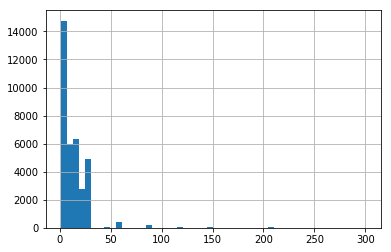

In [109]:
# Missing values are very few in this variable
# Check the distribution
PAQIAF_com['PADTIMES'].hist(bins=50)

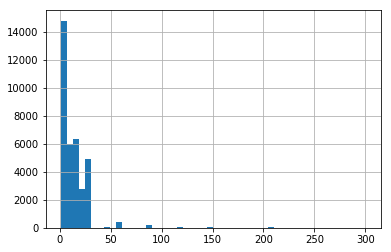

In [110]:
# We use the former value to replace the missing values
PAQIAF_com['PADTIMES'] = PAQIAF_com['PADTIMES'].fillna(method='ffill')
PAQIAF_com['PADTIMES'].hist(bins=50)

In [111]:
PAQIAF_com = PAQIAF_com.groupby('SEQN').mean().reset_index()

In [112]:
PAQIAF_com.to_csv('PAQIAF_com_revised.csv')
df10 = pd.merge(df9, PAQIAF_com, on = 'SEQN', left_index =  True, sort = False)
df10.to_csv('df10.csv',index=False,sep=',')
df10.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,...,mental_visit,home_type,home_ownership,smoker_type,smoking_status,smoking_frequency,smoking_time,work_type,working_hours,PADTIMES
count,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,...,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000
mean,16272.189707,1.521693,37.265414,2.851396,8.611317,3.638679,2.484279,1.227297,3.818725,0.258563,...,1.915159,2.501669,1.391006,1.560162,2.569998,0.350606,0.404356,1.706130,1.242403,11.664061
std,8817.154845,0.499573,11.126942,1.053746,10.323420,1.239415,4.504153,0.419123,18.471469,0.607605,...,0.279928,0.971776,0.531446,0.496411,0.792107,0.805396,0.879929,1.215049,0.900289,13.756137
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,9102.000000,1.000000,27.000000,3.000000,5.000000,3.000000,1.000000,1.000000,1.000000,0.000000,...,2.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,4.000000
50%,16564.000000,2.000000,37.000000,3.000000,8.000000,4.000000,1.000000,1.000000,2.000000,0.000000,...,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000,9.000000
75%,23834.000000,2.000000,46.000000,3.000000,11.000000,5.000000,4.000000,1.000000,3.000000,0.000000,...,2.000000,3.000000,2.000000,2.000000,3.000000,0.000000,0.000000,2.000000,2.000000,14.333333
max,31116.000000,2.000000,59.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,...,2.000000,9.000000,3.000000,2.000000,3.000000,3.000000,3.000000,4.000000,3.000000,300.000000


In [113]:
WHQ = pd.read_sas('WHQ.XPT')
WHQ_B = pd.read_sas('WHQ_B.XPT')
WHQ_C = pd.read_sas('WHQ_C.XPT')

combine = [WHQ, WHQ_B, WHQ_C]

chosen_list = ['SEQN', 'WHD010', 'WHD020','WHQ030','WHD040', 'WHD050']
chosen_list_2 = ['SEQN', 'WHD010', 'WHD020','WHQ030','WHQ040', 'WHD050']

WHQ_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):
    if idx == 0:
        WHQ_idx = combine[idx][chosen_list]
    else:
        WHQ_idx = combine[idx][chosen_list_2]

    WHQ_idx.columns = chosen_list
    WHQ_com = pd.concat([WHQ_com, WHQ_idx])
    
WHQ_com = WHQ_com.applymap(clean_epsilon)
WHQ_com.to_csv('WHQ_com.csv', index = False, sep = ',')
WHQ_com.describe()

,SEQN,WHD010,WHD020,WHQ030,WHD040,WHD050
count,18891.000000,18809.000000,18835.000000,18882.000000,18882.000000,18848.000000
mean,15622.100630,275.293423,966.489886,2.000212,2.294143,1279.244960
std,9024.485131,1423.488025,8435.718063,1.036744,0.699797,10011.247158
min,2.000000,39.000000,50.000000,1.000000,1.000000,55.000000
25%,7773.500000,63.000000,140.000000,1.000000,2.000000,135.000000
50%,15687.000000,66.000000,165.000000,2.000000,2.000000,161.000000
75%,23519.500000,70.000000,194.000000,3.000000,3.000000,192.000000
max,31125.000000,9999.000000,99999.000000,9.000000,9.000000,99999.000000


In [114]:
WHQ_com['WHD010'] = WHQ_com['WHD010'].replace(7777, WHQ_com['WHD010'].dropna().median()).\
                                        replace(9999, WHQ_com['WHD010'].dropna().median()).\
                                        fillna(WHQ_com['WHD010'].dropna().median())

WHQ_com['WHD020'] = WHQ_com['WHD020'].replace(7777, WHQ_com['WHD020'].dropna().median()).\
                                        replace(77777, WHQ_com['WHD020'].dropna().median()).\
                                        replace(9999, WHQ_com['WHD020'].dropna().median()).\
                                        replace(99999, WHQ_com['WHD020'].dropna().median()).\
                                        fillna(WHQ_com['WHD020'].dropna().median())
    
WHQ_com['WHQ030'] = WHQ_com['WHQ030'].replace(7, WHQ_com['WHQ030'].dropna().median()).\
                                        replace(9, WHQ_com['WHQ030'].dropna().median()).\
                                        fillna(WHQ_com['WHQ030'].dropna().median())

WHQ_com['WHD040'] = WHQ_com['WHD040'].replace(7, WHQ_com['WHD040'].dropna().median()).\
                                        replace(9, WHQ_com['WHD040'].dropna().median()).\
                                        fillna(WHQ_com['WHD040'].dropna().median())

WHQ_com['WHD050'] = WHQ_com['WHD050'].replace(77777, WHQ_com['WHD050'].dropna().median()).\
                                        replace(99999, WHQ_com['WHD050'].dropna().median()).\
                                        replace(9999, WHQ_com['WHD050'].dropna().median()).\
                                        replace(7777, WHQ_com['WHD050'].dropna().median()).\
                                        fillna(WHQ_com['WHD050'].dropna().median())

In [115]:
WHQ_com.describe()

,SEQN,WHD010,WHD020,WHQ030,WHD040,WHD050
count,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000
mean,15622.100630,66.345720,169.012810,1.978614,2.276375,167.277222
std,9024.485131,4.127399,41.556157,0.964136,0.618492,43.123385
min,2.000000,39.000000,50.000000,1.000000,1.000000,55.000000
25%,7773.500000,63.000000,140.000000,1.000000,2.000000,135.000000
50%,15687.000000,66.000000,165.000000,2.000000,2.000000,161.000000
75%,23519.500000,69.000000,190.000000,3.000000,3.000000,190.000000
max,31125.000000,83.000000,450.000000,3.000000,3.000000,430.000000


In [116]:
WHQ_com['BMI'] = 0
WHQ_com.BMI = WHQ_com.WHD020 * 0.45359237 / (WHQ_com.WHD010 * 0.0254)**2

In [117]:
WHQ_com['weight_change'] = 0
WHQ_com.weight_change = WHQ_com.WHD020 - WHQ_com.WHD050

In [118]:
WHQ_com.describe()

,SEQN,WHD010,WHD020,WHQ030,WHD040,WHD050,BMI,weight_change
count,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000
mean,15622.100630,66.345720,169.012810,1.978614,2.276375,167.277222,26.935055,1.735588
std,9024.485131,4.127399,41.556157,0.964136,0.618492,43.123385,5.954920,16.848709
min,2.000000,39.000000,50.000000,1.000000,1.000000,55.000000,8.877141,-235.000000
25%,7773.500000,63.000000,140.000000,1.000000,2.000000,135.000000,22.807188,-2.000000
50%,15687.000000,66.000000,165.000000,2.000000,2.000000,161.000000,25.848146,0.000000
75%,23519.500000,69.000000,190.000000,3.000000,3.000000,190.000000,29.914522,9.000000
max,31125.000000,83.000000,450.000000,3.000000,3.000000,430.000000,83.653492,289.000000


In [119]:
WHQ_com.drop(['WHD010','WHD020','WHD050'],axis=1,inplace=True)
WHQ_com.rename(columns = {'WHQ030':'weight_view','WHD040':'change_willing'},inplace = True)

In [120]:
WHQ_com.describe()

,SEQN,weight_view,change_willing,BMI,weight_change
count,18891.000000,18891.000000,18891.000000,18891.000000,18891.000000
mean,15622.100630,1.978614,2.276375,26.935055,1.735588
std,9024.485131,0.964136,0.618492,5.954920,16.848709
min,2.000000,1.000000,1.000000,8.877141,-235.000000
25%,7773.500000,1.000000,2.000000,22.807188,-2.000000
50%,15687.000000,2.000000,2.000000,25.848146,0.000000
75%,23519.500000,3.000000,3.000000,29.914522,9.000000
max,31125.000000,3.000000,3.000000,83.653492,289.000000


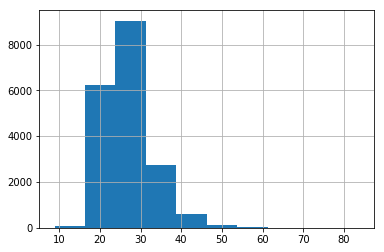

In [121]:
WHQ_com['BMI'].hist()

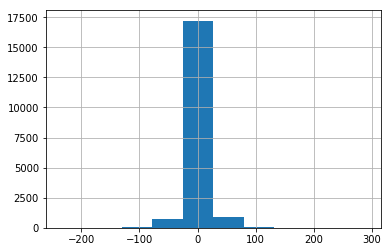

In [122]:
WHQ_com['weight_change'].hist()

In [123]:
WHQ_com['weight_change'] = WHQ_com['weight_change'] * 0.45359237

In [124]:
WHQ_com.to_csv('WHQ_com_revised.csv')
df11 = pd.merge(df10, WHQ_com, on = 'SEQN', left_index =  True, sort = False)
df11.to_csv('df11.csv',index=False,sep=',')
df11.describe()

,SEQN,gender,age,race,FMincome,education,marital_status,alco_frequency,alco_days,drug_status,...,smoking_status,smoking_frequency,smoking_time,work_type,working_hours,PADTIMES,weight_view,change_willing,BMI,weight_change
count,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,...,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000
mean,16272.189707,1.521693,37.265414,2.851396,8.611317,3.638679,2.484279,1.227297,3.818725,0.258563,...,2.569998,0.350606,0.404356,1.706130,1.242403,11.664061,1.827859,2.209204,27.449899,0.636846
std,8817.154845,0.499573,11.126942,1.053746,10.323420,1.239415,4.504153,0.419123,18.471469,0.607605,...,0.792107,0.805396,0.879929,1.215049,0.900289,13.756137,0.959776,0.559188,6.086518,7.710350
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,14.364828,-90.718474
25%,9102.000000,1.000000,27.000000,3.000000,5.000000,3.000000,1.000000,1.000000,1.000000,0.000000,...,3.000000,0.000000,0.000000,1.000000,0.000000,4.000000,1.000000,2.000000,23.172459,-0.907185
50%,16564.000000,2.000000,37.000000,3.000000,8.000000,4.000000,1.000000,1.000000,2.000000,0.000000,...,3.000000,0.000000,0.000000,1.000000,1.000000,9.000000,1.000000,2.000000,26.446483,0.000000
75%,23834.000000,2.000000,46.000000,3.000000,11.000000,5.000000,4.000000,1.000000,3.000000,0.000000,...,3.000000,0.000000,0.000000,2.000000,2.000000,14.333333,3.000000,3.000000,30.409584,3.628739
max,31116.000000,2.000000,59.000000,5.000000,99.000000,9.000000,99.000000,2.000000,365.000000,2.000000,...,3.000000,3.000000,3.000000,4.000000,3.000000,300.000000,3.000000,3.000000,76.120561,77.110703


In [125]:
df_x_new = copy.deepcopy(df11)
df_x_new.to_csv('df_x_new.csv',index=False,sep=',')

In [127]:
CIQPANIC = pd.read_sas('CIQPANIC.XPT')
CIQPANIC_B = pd.read_sas('CIQPAN_B.XPT')
CIQPANIC_C = pd.read_sas('CIQPAN_C.XPT')

combine = [CIQPANIC, CIQPANIC_B, CIQPANIC_C]

chosen_list = ['SEQN', 'CIDPSCOR']

CIQPANIC_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):

    CIQPANIC_idx = combine[idx][chosen_list]


    CIQPANIC_idx.columns = chosen_list
    CIQPANIC_com = pd.concat([CIQPANIC_com, CIQPANIC_idx])
    
CIQPANIC_com = CIQPANIC_com.applymap(clean_epsilon)
CIQPANIC_com.to_csv('CIQPANIC_com.csv', index = False, sep = ',')
CIQPANIC_com.describe()

,SEQN,CIDPSCOR
count,2556.000000,2222.000000
mean,15869.411189,4.911791
std,8886.251803,0.587546
min,12.000000,1.000000
25%,8334.000000,5.000000
50%,15908.500000,5.000000
75%,23707.250000,5.000000
max,31111.000000,5.000000


In [129]:
CIQGAD = pd.read_sas('CIQGAD.XPT')
CIQGAD_B = pd.read_sas('CIQGAD_B.XPT')
CIQGAD_C = pd.read_sas('CIQGAD_C.XPT')

combine = [CIQGAD, CIQGAD_B, CIQGAD_C]

chosen_list = ['SEQN', 'CIDGSCOR']

CIQGAD_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):

    CIQGAD_idx = combine[idx][chosen_list]


    CIQGAD_idx.columns = chosen_list
    CIQGAD_com = pd.concat([CIQGAD_com, CIQGAD_idx])
    
CIQGAD_com = CIQGAD_com.applymap(clean_epsilon)
CIQGAD_com.to_csv('CIQGAD_com.csv', index = False, sep = ',')
CIQGAD_com.describe()

,SEQN,CIDGSCOR
count,2556.000000,2221.000000
mean,15869.411189,4.909950
std,8886.251803,0.593505
min,12.000000,1.000000
25%,8334.000000,5.000000
50%,15908.500000,5.000000
75%,23707.250000,5.000000
max,31111.000000,5.000000


In [130]:
dfy1 = pd.merge(CIQPANIC_com, CIQGAD_com, on = 'SEQN', left_index =  True, sort = False)
dfy1.describe()

,SEQN,CIDPSCOR,CIDGSCOR
count,2556.000000,2222.000000,2221.000000
mean,15869.411189,4.911791,4.909950
std,8886.251803,0.587546,0.593505
min,12.000000,1.000000,1.000000
25%,8334.000000,5.000000,5.000000
50%,15908.500000,5.000000,5.000000
75%,23707.250000,5.000000,5.000000
max,31111.000000,5.000000,5.000000


In [131]:
CIQDEP = pd.read_sas('CIQMDEP.XPT')
CIQDEP_B = pd.read_sas('CIQDEP_B.XPT')
CIQDEP_C = pd.read_sas('CIQDEP_C.XPT')

combine = [CIQDEP, CIQDEP_B, CIQDEP_C]

chosen_list = ['SEQN', 'CIDDSCOR']

CIQDEP_com = pd.DataFrame(columns = chosen_list)

for idx, df in enumerate(combine):

    CIQDEP_idx = combine[idx][chosen_list]


    CIQDEP_idx.columns = chosen_list
    CIQDEP_com = pd.concat([CIQDEP_com, CIQDEP_idx])
    
CIQDEP_com = CIQDEP_com.applymap(clean_epsilon)
CIQDEP_com.to_csv('CIQDEP_com.csv', index = False, sep = ',')
CIQDEP_com.describe()

,SEQN,CIDDSCOR
count,2556.000000,2217.000000
mean,15869.411189,4.732972
std,8886.251803,0.998627
min,12.000000,1.000000
25%,8334.000000,5.000000
50%,15908.500000,5.000000
75%,23707.250000,5.000000
max,31111.000000,5.000000


In [132]:
dfy = pd.merge(dfy1, CIQDEP_com, on = 'SEQN', left_index =  True, sort = False)
dfy.describe()

,SEQN,CIDPSCOR,CIDGSCOR,CIDDSCOR
count,2556.000000,2222.000000,2221.000000,2217.000000
mean,15869.411189,4.911791,4.909950,4.732972
std,8886.251803,0.587546,0.593505,0.998627
min,12.000000,1.000000,1.000000,1.000000
25%,8334.000000,5.000000,5.000000,5.000000
50%,15908.500000,5.000000,5.000000,5.000000
75%,23707.250000,5.000000,5.000000,5.000000
max,31111.000000,5.000000,5.000000,5.000000


In [133]:
dfy.dropna(inplace=True)

In [134]:
dfy.describe()

,SEQN,CIDPSCOR,CIDGSCOR,CIDDSCOR
count,2215.000000,2215.000000,2215.000000,2215.000000
mean,15468.581941,4.913318,4.909707,4.734537
std,8870.682937,0.582552,0.594290,0.995906
min,12.000000,1.000000,1.000000,1.000000
25%,7683.000000,5.000000,5.000000,5.000000
50%,15453.000000,5.000000,5.000000,5.000000
75%,23283.500000,5.000000,5.000000,5.000000
max,31111.000000,5.000000,5.000000,5.000000


In [135]:
dfy.to_csv('dfy.csv', index = False, sep = ',')

In [136]:
df_xy_new = pd.merge(dfy, df_x_new, on = 'SEQN', left_index =  True, sort = False)

In [137]:
df_xy_new.to_csv('df_xy_new.csv', index = False, sep = ',')